When a file loading error occurs during execution, please import the two CSV files (train and test) directly into the content folder, as we do not know how to fix this issue.

# Load data

---



In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import set_config


print(os.listdir())

cols = [
    "Unnamed: 0", "id", "Gender", "Customer Type", "Age", "Type of Travel", "Class",
    "Flight Distance", "Inflight wifi service", "Departure/Arrival time convenient",
    "Ease of Online booking", "Gate location", "Food and drink", "Online boarding",
    "Seat comfort", "Inflight entertainment", "On-board service", "Leg room service",
    "Baggage handling", "Checkin service", "Inflight service", "Cleanliness",
    "Departure Delay in Minutes", "Arrival Delay in Minutes", "satisfaction"
]


train = pd.read_csv(
    "train.csv",
    header=None,
    names=cols,
    skiprows=1,
    engine="python",
    on_bad_lines="skip"
)

test = pd.read_csv("test.csv")

print("train:", train.shape)
print("test :", test.shape)


print("Lignes attendues train ~103904, lignes chargées:", len(train))


['.config', 'test.csv', 'train.csv', 'sample_data']
train: (103904, 25)
test : (25976, 25)
Lignes attendues train ~103904, lignes chargées: 103904


# Cleaning

In [2]:
train = train.drop(columns=["Unnamed: 0", "id"], errors="ignore")
test  = test.drop(columns=["Unnamed: 0", "id"], errors="ignore")


# EDA

In [3]:
train["satisfaction"].value_counts()
train["satisfaction"].value_counts(normalize=True)


,proportion
satisfaction,
neutral or dissatisfied,0.566667
satisfied,0.433333


In [4]:
train = train.rename(columns={5: 'satisfaction'})

In [5]:




def satisfied_rate(df, col):
    tab = pd.crosstab(df[col], df["satisfaction"], normalize="index")
    return (tab["satisfied"]*100).round(1).sort_values(ascending=False)

for col in ["Type of Travel", "Class", "Customer Type"]:
    print("\n", col)
    print(satisfied_rate(train, col))



 Type of Travel
Type of Travel
Business travel    58.3
Personal Travel    10.2
Name: satisfied, dtype: float64

 Class
Class
Business    69.4
Eco Plus    24.6
Eco         18.6
Name: satisfied, dtype: float64

 Customer Type
Customer Type
Loyal Customer       47.7
disloyal Customer    23.7
Name: satisfied, dtype: float64


In [6]:
num_cols = train.select_dtypes(include=np.number).columns
means = train.groupby("satisfaction")[num_cols].mean(numeric_only=True)
diff = (means.loc["satisfied"] - means.loc["neutral or dissatisfied"]).sort_values(ascending=False)
diff.head(15)



,0
Flight Distance,601.220284
Age,4.183895
Online boarding,1.371348
Inflight entertainment,1.070775
Seat comfort,0.930235
On-board service,0.838166
Leg room service,0.831332
Cleanliness,0.808219
Inflight wifi service,0.761655
Checkin service,0.603089


In [7]:
train.isna().sum().sort_values(ascending=False).head(10)
test.isna().sum().sort_values(ascending=False).head(10)


,0
Arrival Delay in Minutes,83
Customer Type,0
Gender,0
Type of Travel,0
Class,0
Flight Distance,0
Age,0
Inflight wifi service,0
Departure/Arrival time convenient,0
Gate location,0


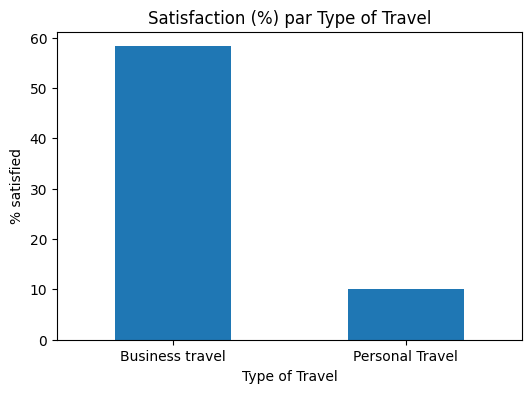

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

rate_travel = (
    train.groupby("Type of Travel")["satisfaction"]
    .apply(lambda s: (s == "satisfied").mean() * 100)
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,4))
rate_travel.plot(kind="bar")
plt.ylabel("% satisfied")
plt.title("Satisfaction (%) par Type of Travel")
plt.xticks(rotation=0)
plt.savefig("satisfaction_type_travel.png", dpi=200, bbox_inches="tight")
plt.show()


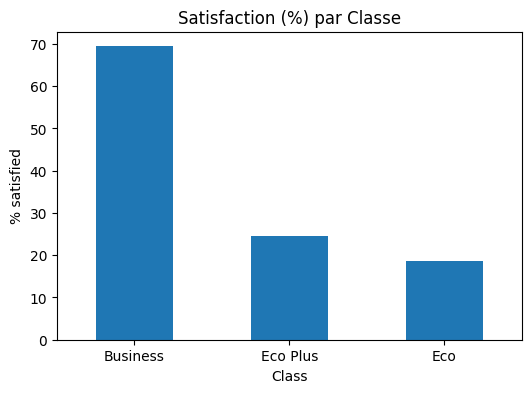

In [9]:
rate_class = (
    train.groupby("Class")["satisfaction"]
    .apply(lambda s: (s == "satisfied").mean() * 100)
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,4))
rate_class.plot(kind="bar")
plt.ylabel("% satisfied")
plt.title("Satisfaction (%) par Classe")
plt.xticks(rotation=0)
plt.savefig("satisfaction_class.png", dpi=200, bbox_inches="tight")
plt.show()


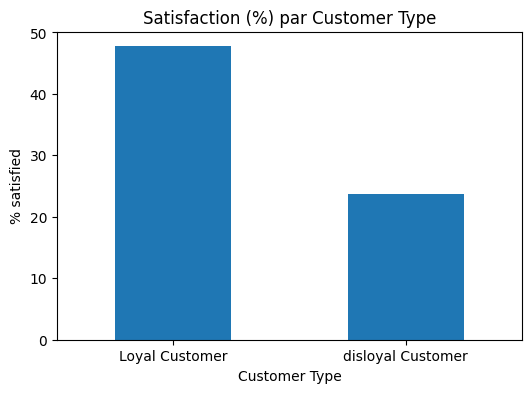

In [10]:
rate_customer = (
    train.groupby("Customer Type")["satisfaction"]
    .apply(lambda s: (s == "satisfied").mean() * 100)
    .sort_values(ascending=False)
)

plt.figure(figsize=(6,4))
rate_customer.plot(kind="bar")
plt.ylabel("% satisfied")
plt.title("Satisfaction (%) par Customer Type")
plt.xticks(rotation=0)
plt.savefig("satisfaction_customer_type.png", dpi=200, bbox_inches="tight")
plt.show()


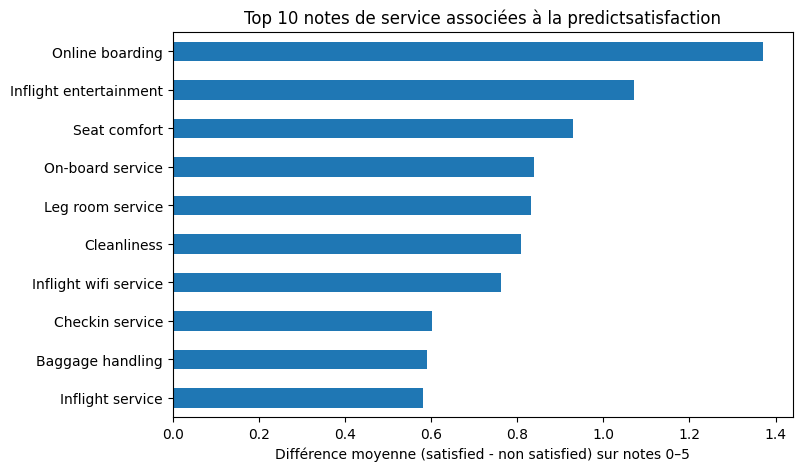

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Colonnes "notes" : numériques entre 0 et 5
rating_cols = []
for c in train.columns:
    if train[c].dtype != "object" and c not in ["Arrival Delay in Minutes", "Departure Delay in Minutes", "Flight Distance", "Age"]:
        # on garde celles dont le max <= 5 (notes)
        if train[c].max() <= 5:
            rating_cols.append(c)

means = train.groupby("satisfaction")[rating_cols].mean(numeric_only=True)
diff = (means.loc["satisfied"] - means.loc["neutral or dissatisfied"]).sort_values(ascending=False)

top10 = diff.head(10)

plt.figure(figsize=(8,5))
top10.sort_values().plot(kind="barh")
plt.xlabel("Différence moyenne (satisfied - non satisfied) sur notes 0–5")
plt.title("Top 10 notes de service associées à la predictsatisfaction")
plt.savefig("top10_service_notes.png", dpi=200, bbox_inches="tight")
plt.show()


# Modeling

In [12]:
y_train = (train["satisfaction"] == "satisfied").astype(int)
X_train = train.drop(columns=["satisfaction"])

y_test  = (test["satisfaction"] == "satisfied").astype(int)
X_test  = test.drop(columns=["satisfaction"])


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

cat_cols = X_train.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("AUC:", roc_auc_score(y_test, proba))


              precision    recall  f1-score   support

           0       0.87      0.90      0.89     14573
           1       0.87      0.83      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976

Confusion matrix:
 [[13145  1428]
 [ 1901  9502]]
AUC: 0.9255960907308116


In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("satisfaction" in X_train.columns, "satisfaction" in X_test.columns)
y_train.value_counts()


(103904, 22) (103904,)
(25976, 22) (25976,)
False False


,count
satisfaction,
0,58879
1,45025


In [15]:
pipe.fit(X_train, y_train)
pipe


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight Distance',
                                                   'Inflight wifi service',
                                                   'Departure/Arrival time '
                                                   'convenient',
                                                   'Ease of Online booking',
                                                   'Gate location',
                                                   'Food and drink',
                                                   'Online boarding',
                                                   'Seat comfort',
                                                   'Inflight entertainment',
                                                   '...
                                                   'Leg room service',
                                                   'Baggage handling',
                                                   'Checkin service',
                                                   'Inflight service',
                                                   'Cleanliness',
                                                   'Departure Delay in Minutes',
                                                   'Arrival Delay in Minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel',
                                                   'Class'])])),
                ('model', LogisticRegression(max_iter=2000))])

# Results

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))


              precision    recall  f1-score   support

           0       0.87      0.90      0.89     14573
           1       0.87      0.83      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976

[[13145  1428]
 [ 1901  9502]]


# Interpretation
---



In [17]:
import numpy as np
import pandas as pd

preprocess_fitted = pipe.named_steps["preprocess"]
ohe = preprocess_fitted.named_transformers_["cat"].named_steps["onehot"]

cat_cols = preprocess_fitted.transformers_[1][2]
num_cols = preprocess_fitted.transformers_[0][2]

feature_names = np.r_[num_cols, ohe.get_feature_names_out(cat_cols)]
coefs = pipe.named_steps["model"].coef_.ravel()

imp = pd.Series(coefs, index=feature_names)

print("TOP 10 qui diminuent la satisfaction (coeff négatifs) :")
print(imp.sort_values().head(10))

print("\nTOP 10 qui augmentent la satisfaction (coeff positifs) :")
print(imp.sort_values().tail(10))


TOP 10 qui diminuent la satisfaction (coeff négatifs) :
Type of Travel_Personal Travel      -1.677014
Customer Type_disloyal Customer     -1.336342
Class_Eco Plus                      -0.539068
Class_Eco                           -0.418486
Gender_Female                       -0.338938
Arrival Delay in Minutes            -0.336245
Gender_Male                         -0.297790
Ease of Online booking              -0.199632
Departure/Arrival time convenient   -0.190456
Age                                 -0.126120
dtype: float64

TOP 10 qui augmentent la satisfaction (coeff positifs) :
Baggage handling                  0.157571
Cleanliness                       0.290160
Class_Business                    0.320826
Leg room service                  0.332563
On-board service                  0.388250
Checkin service                   0.409951
Inflight wifi service             0.523921
Customer Type_Loyal Customer      0.699614
Online boarding                   0.825827
Type of Travel_Business 